In [ ]:
! pip install pycuda

In [2]:
!nvidia-smi

Fri Oct 30 15:14:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [4]:
import numpy as np
np.random.seed(0) 

import pycuda.autoinit
from pycuda import driver, gpuarray
from pycuda.compiler import SourceModule
import time

In [5]:
# multiplication functions

## GPU
mod = SourceModule("""
        __global__ void mult_gpu(double* A, double* B, double* C){
                const int row =  threadIdx.y + blockIdx.y * blockDim.y;
                const int column = threadIdx.x + blockIdx.x * blockDim.x;
                const int N = 128;
                for(int i = 0; i < N; i++){
                        C[column + row * N] += A[i + row * N] * B[column + i * N];              
                }       
        }
""")

## simple CPU function
def mult_cpu(A, B):
    C, n  = np.zeros((N, N)), range(N)
    for i in n:
        for j in n:
            for k in n:
                C[i, j] += A[i, k] * B[k, j]
    return C

In [8]:
sizes = [128, 256, 512, 1024, 2048]
N = sizes[0] # matrix size

# matrix
A, B, C_gpu= np.random.randn(N, N).astype(np.float), np.random.randn(N, N).astype(np.float), np.ones((N, N)).astype(np.float)

In [10]:
# GPU multiplication

## preparing
block_size = [2, 2]
block, grid = (block_size[0], block_size[1], 1), (int((N + block_size[0] - 1) / 2), int((N + block_size[1] - 1) / 2))
mult = mod.get_function("mult_gpu")


## multiplication
start_gpu = time.time()
mult(driver.In(A), driver.In(B), driver.Out(C_gpu), block = block, grid = grid)
driver.Context.synchronize()
time_gpu = time.time() - start_gpu

In [11]:
# CPU multiplication 
start_cpu = time.time()
C_cpu = mult_cpu(A, B)
time_cpu = time.time() - start_cpu

In [13]:
# results
print('GPU time: ', round(time_gpu, 4))
print('CPU time: ', round(time_cpu, 4))

print('Results converge;  acceleration: ', round(time_cpu/time_gpu, 4)) if np.allclose(C_gpu, C_cpu) else print('Results do not converge')

GPU time:  0.0041
CPU time:  1.5273
Results converge;  acceleration:  372.579


# <center> **Results:** </center>

<table>
<thead>
<tr><th>Size</th><th>CPU time</th><th>GPU time</th><th>Acceleration</th></tr>
</thead>
<tbody>
<tr><td>128</td><td> 1.5273</td><td>0.0041</td><td>372.579</td></tr>
<tr><td>256</td><td> 11.5251</td><td>0.0032</td><td>3599.9234</td></tr>
<tr><td>512</td><td> 93.4048</td><td>0.0113</td><td>8254.5239</td></tr>
<tr><td>1024</td><td> 859.1499</td><td>0.0493</td><td>17435.5929</td></tr>
<tr><td>2048</td><td> 6723.3339</td><td>0.326</td><td>20621.3875</td></tr>
</tbody>
</table>

In [14]:
# visualization results
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd


cpu_time = [1.5273, 11.5251, 93.4048, 859.1499, 6723.3339]
gpu_time = [0.0041, 0.0032, 	0.0113, 0.0493, 0.326]
acceleration = [372.579, 3599.9234, 8254.5239, 17435.5929, 20621.3875]

result= pd.DataFrame({'cpu_time': cpu_time, 'gpu_time': gpu_time, 'acceleration': acceleration, 'size': sizes})
result = result.set_index('size')
result.head()

,cpu_time,gpu_time,acceleration
size,,,
128,1.5273,0.0041,372.5790
256,11.5251,0.0032,3599.9234
512,93.4048,0.0113,8254.5239
1024,859.1499,0.0493,17435.5929
2048,6723.3339,0.3260,20621.3875


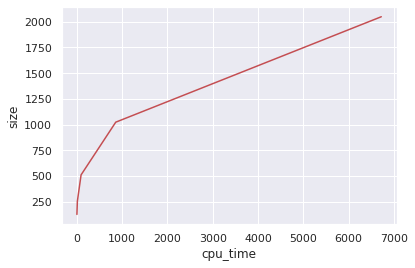

In [15]:
sns.lineplot(x="cpu_time", y="size", data=result, color='r')

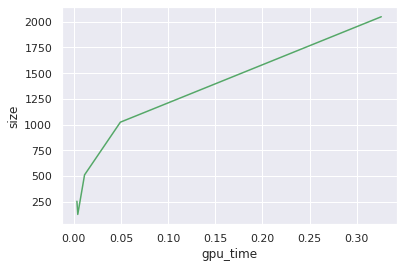

In [16]:
sns.lineplot(x="gpu_time", y="size", data=result, color='g')

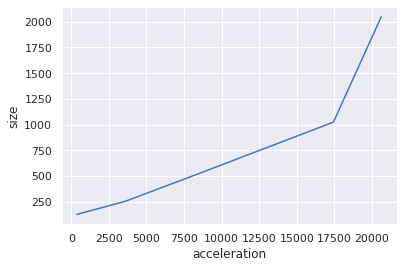

In [17]:
sns.lineplot(x="acceleration", y="size", data=result, color='b')